# Study on Yelp-Hat

Paper: https://davis.wpi.edu/dsrg/PROJECTS/YELPHAT/2020_ACL_Human_vs_Machine-2.pdf

Summary:
* __Do annotators carefully choose relevant words?__ Yes, as the collecting time and number of chosen words increase accross the sentence length.

Sigles:
* __HAM__ (Human Attention Map): what annotators denote
* __CAM__ (Consensus Attention Map): bitwise __AND__ operation of the HAMs
* __SAM__ (Super Attention Map): bitwise __OR__ operation of the HAMs. 


In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import os
from os import path

import sys
sys.path.append("./../src")

cache_path = path.join(os.getcwd(), '..', '.cache')

DATASET_NAME='yelp-hat'

dataset_path = path.join(cache_path, 'dataset', DATASET_NAME)

tmp_path = path.join('.cache', '2022-07-29')
os.makedirs(tmp_path,exist_ok=True)

Download and extract dataset

In [2]:
from torchtext.utils import download_from_url, extract_archive
import shutil

# Download dataset zip
URL='https://github.com/cansusen/Human-Attention-for-Text-Classification/archive/205c1552bc7be7ec48623d79d85d4c6fbfe62362.zip'

zip_path = download_from_url(URL, root=dataset_path, path=path.join(dataset_path, f'{DATASET_NAME}.zip'))
extracted_path = path.join(dataset_path, 'caching')
files = extract_archive(from_path=zip_path, to_path=extracted_path)
files = [f for f in files if f.endswith('.csv')]

for f in files: shutil.copy2(f, extracted_path)

A quoi ressemble la dataset?

In [3]:
import pandas as pd

df = pd.read_csv(path.join(extracted_path, 'ham_part1(50words).csv'))
df

,Input.label,Input.text,Answer.Q1Answer,Answer.html_output
0,1,Out in Twinsburg for work and wasn't expecting...,yes,<span>Out</span> <span>in</span> <span>Twinsbu...
1,1,Out in Twinsburg for work and wasn't expecting...,yes,<span>Out</span> <span>in</span> <span>Twinsbu...
2,1,Out in Twinsburg for work and wasn't expecting...,yes,<span>Out</span> <span>in</span> <span>Twinsbu...
3,0,Very slow. Never been in the drive at any othe...,no,"<span class=""active"">Very</span> <span class=""..."
4,0,Very slow. Never been in the drive at any othe...,no,"<span>Very</span> <span class=""active"">slow.</..."
...,...,...,...,...
895,0,I went here to get a snack before I went on th...,no,<span>I</span> <span>went</span> <span>here</s...
896,0,I went here to get a snack before I went on th...,no,<span>I</span> <span>went</span> <span>here</s...
897,0,Always packed for lunch. Probably because Pit...,no,<span>Always</span> <span>packed</span> <span>...
898,0,Always packed for lunch. Probably because Pit...,no,<span>Always</span> <span>packed</span> <span>...


In [4]:
import re
def generate_binary_human_attention_vector(html, num_words_in_review, max_words):
    # Function provided by the dataset :
    # https://github.com/cansusen/Human-Attention-for-Text-Classification/blob/master/generate_ham/sample_generate.ipynb

    p = re.compile('<span(.*?)/span>')
    all_span_items = p.findall(html)

    if html == '{}':
        print('Empty human annotation - This should never print')
        return [0] * max_words

    if len(all_span_items) == num_words_in_review + 1:
        if (all_span_items[num_words_in_review] == '><') or (all_span_items[num_words_in_review] == ' data-vivaldi-spatnav-clickable="1"><'):

            binarized_human_attention = [0] * max_words
            for i in range(0, len(all_span_items) - 1):
                if 'class="active"' in all_span_items[i]:
                    binarized_human_attention[i] = 1

        else:
            print('This should never print.')
    else:
        print('This should never print.')

    return binarized_human_attention

MAX_WORDS = 100
i = 0
html = df['Answer.html_output'][i]
num_highlighted = html.count('class="active"')
num_words_in_review = len(df['Input.text'][i].split())

binarized_human_attention = generate_binary_human_attention_vector(html, num_words_in_review, MAX_WORDS)


print("Number of words highlighted in this review:",num_highlighted)
print("Original annotation:", html)
print("Binarized attention map:",binarized_human_attention)

Number of words highlighted in this review: 6
Original annotation: <span>Out</span> <span>in</span> <span>Twinsburg</span> <span>for</span> <span>work</span> <span>and</span> <span>wasn't</span> <span>expecting</span> <span>to</span> <span>find</span> <span>a</span> <span>well</span> <span>reviewed</span> <span>sushi</span> <span>restaurant</span> <span>but</span> <span class="active">glad</span> <span>I</span> <span>did.</span> <span>It</span> <span>was</span> <span>quite</span> <span>busy</span> <span>for</span> <span>a</span> <span>Monday</span> <span>and</span> <span>the</span> <span>poor</span> <span>waitress</span> <span>was</span> <span>slammed</span> <span>but</span> <span>the</span> <span>sushi</span> <span>chef</span> <span>stepped</span> <span>in</span> <span>to</span> <span>help</span> <span>and</span> <span>was</span> <span class="active">very</span> <span class="active">friendly.</span> <span>The</span> <span class="active">presentation</span> <span>and</span> <span class

In [6]:
def tokenize(html):
    p = re.compile(r'<span[^>]*>(.+?)</span>')
    return p.findall(html)

def human_attention(html):

    p = re.compile('<span(.*?)/span>')
    all_span_items = p.findall(html)
    if all_span_items[-1] == '><': all_span_items = all_span_items[:-1]

    return ['class="active"' in span_item for span_item in all_span_items]

v_hat = human_attention(html)
print(v_hat)

# Check if we tokenize html, can our function "human_attention" reproduce the exact same length
for fpath in os.listdir(dataset_path):
    
    if fpath.endswith('.csv'):
        print('Check',fpath)
        df = pd.read_csv(path.join(dataset_path, fpath))
        print(len(df['Answer.html_output']))
        for html in df['Answer.html_output']:
            tokens = tokenize(html)
            v_hat = human_attention(html)
            if len(tokens) != len(v_hat):
                print(len(tokens), len(v_hat))
                print(' '.tokens)
                display(HTML(html))

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, True, False, True, False, True]


Proceed dataset step by step

In [8]:
from data.yelp_hat.utils import yelp_hat_ham, yelp_hat_token
import numpy as np
import spacy

nlp = spacy.load('en_core_web_sm')

df = pd.read_csv(path.join(extracted_path, 'ham_part5.csv'))
display(HTML('<h3>Raw dataset</h3>'))
display(df.head())

dupli_2 = duplicates[duplicates['size'] == 2]  # finds dupli_2
df = df[~df['Input.text'].isin(dupli_2['index'])]

df['ham_'] = df[f'Answer.html_output'].apply(lambda x: yelp_hat_ham(x, nlp)).apply(lambda x: np.array(x))
df['text_tokens'] = df['Answer.html_output'].apply(lambda x: yelp_hat_token(x, nlp))
df = df.rename(columns={'Answer.Q1Answer': 'human_label_', 'Input.text': 'text', 'Input.label': 'label'})

display(HTML('<h3>Preprocess text and human attention</h3>'))
display(df.head())

dfs = [df.loc[0::3, ['text', 'label', 'text_tokens']].reset_index(drop=True)]
for idx in range(3):
    _data = df.loc[idx::3, ['ham_', 'human_label_']]
    _data = _data.reset_index(drop=True).add_suffix(str(idx))
    dfs += [_data]
    
df = pd.concat(dfs, axis=1)

def cam(row):
    return np.logical_and(row['ham_0'],row['ham_1'],row['ham_2'])

def sam(row):
    return np.logical_or(row['ham_0'],row['ham_1'],row['ham_2'])

def ham(row):
    return ((row['ham_0'] + row['ham_1'] + row['ham_2'])/3 >= 0.5).astype(int)

df['cam'] = df.apply(cam,axis=1)
df['sam'] = df.apply(sam,axis=1)
df['ham'] = df.apply(ham,axis=1)

df.head()

,Input.label,Input.text,Answer.Q1Answer,Answer.html_output
0,0,"I don't think so. \n\nThis ""buffet"" is probabl...",no,<span>I</span> <span>don't</span> <span>think<...
1,0,"I don't think so. \n\nThis ""buffet"" is probabl...",no,"<span>I</span> <span class=""active"">don't</spa..."
2,0,"I don't think so. \n\nThis ""buffet"" is probabl...",no,<span>I</span> <span>don't</span> <span>think<...
3,1,Ate here two times now and food has been excel...,yes,<span>Ate</span> <span>here</span> <span>two</...
4,1,Ate here two times now and food has been excel...,yes,<span>Ate</span> <span>here</span> <span>two</...


NameError: name 'duplicates' is not defined

In [ ]:
df = pd.read_csv(path.join(extracted_path, 'ham_part5.csv'))
duplicates = df.groupby(df['Input.text'].tolist(),as_index=False).size()
display(duplicates['size'].unique())
for dup_rows in [2, 3]:
    print('Duplicate of', dup_rows, ':', sum(duplicate['size'] == dup_rows))
    
dupli_2 = duplicates[duplicates['size'] == 2]  # finds dupli_2
df = df[~df['Input.text'].isin(dupli_2['index'])]
duplicate = df.groupby(df['Input.text'].tolist(),as_index=False).size()
display(duplicate['size'].unique())

In [ ]:
df['coherent_ham_01'] = df['ham_0'].str.len() == df['ham_1'].str.len()
df['coherent_ham_12'] = df['ham_1'].str.len() == df['ham_2'].str.len()
print(df['coherent_ham_01'].all())
print(df['coherent_ham_12'].all())
print('#Incoherent length:', df['coherent_ham_12'].sum())

In [ ]:
def cam(row):
    return np.logical_and(row['ham_0'],row['ham_1'],row['ham_2'])

def sam(row):
    return np.logical_or(row['ham_0'],row['ham_1'],row['ham_2'])

def ham(row):
    return ((row['ham_0'] + row['ham_1'] + row['ham_2'])/3 >= 0.5).astype(int)

for f in files:
    print(f)
    df = pd.read_csv(f)
    df['ham_'] = df[f'Answer.html_output'].apply(yelp_hat_ham).apply(lambda x: np.array(x))
    df['text_tokens'] = df['Answer.html_output'].apply(yelp_hat_token)
    df = df.rename(columns={'Answer.Q1Answer': 'human_label_', 'Input.text': 'text', 'Input.label': 'label'})
    dfs = [df.loc[0::3, ['text', 'label', 'text_tokens']].reset_index(drop=True)]
    for idx in range(3):
        _data = df.loc[idx::3, ['ham_', 'human_label_']]
        _data = _data.reset_index(drop=True).add_suffix(str(idx))
        dfs += [_data]

    df = pd.concat(dfs, axis=1)

    try:
        df['cam'] = df.apply(cam,axis=1)
        df['sam'] = df.apply(sam,axis=1)
        df['ham'] = df.apply(ham,axis=1)
    except ValueError as e:
        print(e)
        continue

In [ ]:
import numpy as np

def cam(row):
    return np.logical_and(row['ham_0'],row['ham_1'],row['ham_2'])

def sam(row):
    return np.logical_or(row['ham_0'],row['ham_1'],row['ham_2'])

def ham(row):
    return ((row['ham_0'] + row['ham_1'] + row['ham_2'])/3 >= 0.5).astype(int)

df['cam'] = df.apply(cam,axis=1)
df['sam'] = df.apply(sam,axis=1)
df['ham'] = df.apply(ham,axis=1)
df.head()
# sam = df.apply(lambda x: np.logical_and(np.array(x['ham_0']), np.array(x['ham_1']), np.array(x['ham_2'])))

<div class="alert alert-block alert-info">
    <b>Note:</b> By reconcatenating for spacy and re tokenize, do we obtain the coherent length?
</div>    

In [134]:
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import spacy 

nlp = spacy.load('en_core_web_sm')
# soup = BeautifulSoup(html, 'html.parser')

def tokenize_ham(html):
    soup = BeautifulSoup(html, 'html.parser')
    tags = [str(tag.string) for tag in soup.find_all('span') if tag.string is not None]
    tokens = [str(tk.text) for doc in nlp.pipe(tags) for tk in doc]
    return tokens

files = [fpath for fpath in os.listdir(extracted_path) if fpath.endswith('.csv') and 'part7' not in fpath]

for fpath in tqdm(files, total=len(files)):
        
    df = pd.read_csv(path.join(extracted_path, fpath))

    dfs = [df.loc[0::3, df.columns != 'Answer.html_output'].reset_index(drop=True)]
    dfs += [df.loc[idx::3, ['Answer.html_output']].reset_index(drop=True).rename(columns={'Answer.html_output':'ham_html_'}).add_suffix(str(idx)) for idx in range(3) ]
    clean_df = pd.concat(dfs,axis=1).rename(columns={'Input.label': 'label', 'Input.text': 'text', 'Answer.Q1Answer':'human_label'})
    clean_df = clean_df[['text', 'ham_html_0', 'ham_html_1', 'ham_html_2', 'label', 'human_label']]

    clean_df['ham_tokens'] = clean_df['ham_html_0'].apply(tokenize_ham)
    clean_df['count_ham_tokens'] = clean_df['ham_tokens'].apply(lambda row: len(row))

    clean_df['text_tokens'] = [[tk.text for tk in doc if not tk.is_space] for doc in nlp.pipe(clean_df['text'].tolist())]
    clean_df['count_text_tokens'] = clean_df['text_tokens'].apply(lambda row: len(row))

    is_every_row_ok = (clean_df['count_text_tokens'] == clean_df['count_ham_tokens']).all()
    print(fpath, ': Same tokens between text and ham >', is_every_row_ok)

  0%|          | 0/6 [00:00<?, ?it/s]

ham_part5.csv : Same tokens between text and ham > True
ham_part8(200words).csv : Same tokens between text and ham > True
ham_part6(100words).csv : Same tokens between text and ham > True
ham_part4.csv : Same tokens between text and ham > True
ham_part3.csv : Same tokens between text and ham > True
ham_part1(50words).csv : Same tokens between text and ham > True


###### Split tokens in human attention maps by spacy, verify if `len(token) == len(annotation)`

In [ ]:
def binarize_ham(html):
    soup = BeautifulSoup(html, 'html.parser')
    tags = [tag for tag in soup.find_all('span') if tag.string is not None]
    
    tag_annot = [int('active' in t.get('class', [])) for t in tags]
    tag_str = [str(t.string) for t in tags]
    
    ham = []
    
    for annot, splitted_tokens in zip(tag_annot, nlp.pipe(tag_str)):
        annotation = [annot * int(not tk.is_punct) for tk in splitted_tokens]
        ham += annotation
    
    return ham

html = clean_df['ham_html_0']
print(html[0])
print(tokenize_ham(html[0]))

In [ ]:
files = [fpath for fpath in os.listdir(dataset_path) if fpath.endswith('.csv') and 'part7' not in fpath]

for fpath in tqdm(files, total=len(files)):
        
    df = pd.read_csv(path.join(dataset_path, fpath))

    dfs = [df.loc[0::3, df.columns != 'Answer.html_output'].reset_index(drop=True)]
    dfs += [df.loc[idx::3, ['Answer.html_output']].reset_index(drop=True).rename(columns={'Answer.html_output':'annotation_html_'}).add_suffix(str(idx)) for idx in range(3) ]
    clean_df = pd.concat(dfs,axis=1).rename(columns={'Input.label': 'label', 'Input.text': 'text', 'Answer.Q1Answer':'human_label'})
    clean_df = clean_df[['text', 'ham_html_0', 'ham_html_1', 'ham_html_2', 'label', 'human_label']]

    clean_df['ham_tokens'] = clean_df['ham_html_0'].apply(binarize_ham)
    clean_df['count_ham_tokens'] = clean_df['ham_tokens'].apply(lambda row: len(row))

    clean_df['text_tokens'] = [[tk.text for tk in doc if not tk.is_space] for doc in nlp.pipe(clean_df['text'].tolist())]
    clean_df['count_text_tokens'] = clean_df['text_tokens'].apply(lambda row: len(row))

    is_every_row_ok = (clean_df['count_text_tokens'] == clean_df['count_ham_tokens']).all()
    print(fpath, ': Same tokens between text and ham >', is_every_row_ok)

## Check sentence length

In [30]:
for fpath in tqdm(files, total=len(files)):
        
    df = pd.read_csv(path.join(dataset_path, fpath))
    display(HTML(f'<h3>{fpath}</h3>'))
    dfs = [df.loc[0::3, df.columns != 'Answer.html_output'].reset_index(drop=True)]
    dfs += [df.loc[idx::3, ['Answer.html_output']].reset_index(drop=True).rename(columns={'Answer.html_output':'ham_html_'}).add_suffix(str(idx)) for idx in range(3) ]
    clean_df = pd.concat(dfs,axis=1).rename(columns={'Input.label': 'label', 'Input.text': 'text', 'Answer.Q1Answer':'human_label'})
    clean_df = clean_df[['text', 'ham_html_0', 'ham_html_1', 'ham_html_2', 'label', 'human_label']]
    clean_df['text_tokens'] = [[tk.text for tk in doc if not tk.is_space] for doc in nlp.pipe(clean_df['text'].tolist())]
    
    clean_df['text_length'] = clean_df.text_tokens.str.len()
    display(clean_df.describe().transpose())

  0%|          | 0/6 [00:00<?, ?it/s]

,count,mean,std,min,25%,50%,75%,max
label,1000.0,0.516,0.499994,0.0,0.0,1.0,1.0,1.0
text_length,1000.0,71.694,7.983865,55.0,66.0,71.0,78.0,97.0


,count,mean,std,min,25%,50%,75%,max
label,181.0,0.508287,0.501318,0.0,0.0,1.0,1.0,1.0
text_length,181.0,230.071823,8.317340,210.0,224.0,230.0,235.0,252.0


,count,mean,std,min,25%,50%,75%,max
label,438.0,0.513699,0.500384,0.0,0.0,1.0,1.0,1.0
text_length,438.0,115.276256,5.565827,101.0,112.0,114.0,118.0,144.0


,count,mean,std,min,25%,50%,75%,max
label,1000.0,0.507,0.500201,0.0,0.0,1.0,1.0,1.0
text_length,1000.0,71.604,7.837641,55.0,65.0,71.0,78.0,101.0


,count,mean,std,min,25%,50%,75%,max
label,1000.0,0.497,0.500241,0.0,0.0,0.0,1.0,1.0
text_length,1000.0,71.958,8.178944,53.0,65.0,72.0,78.0,107.0


,count,mean,std,min,25%,50%,75%,max
label,300.0,0.483333,0.500557,0.0,0.0,0.0,1.0,1.0
text_length,300.0,58.006667,3.009454,50.0,56.0,57.0,60.0,72.0


## Test dataset

In [9]:
from data_module.yelp_hat import YelpHatDM
dm = YelpHatDM(cache_path=path.join(cache_path, 'dataset'), batch_size=4)

In [18]:
dm.prepare_data()
dm.setup()
dataloader = dm.train_dataloader()

In [21]:
b = next(iter(dataloader))
tokens = [dm.vocab.lookup_tokens(token_ids.tolist()) for token_ids in b['token_ids']]
[' '.join(tk) for tk in tokens]

['i be there for lunch last wednedsay base on all the review . i be craving pasta , and that be the only thing i order . their home make spicy pasta sauce be ok . probably because of lunch time , there be no one except for we ( 12:00 till 1:00 ) for the price of the pasta , the quality of the pasta be just a little well than il fornello but for a little bit more .',
 "brother 's have always be an excellent place for a donair . it be worth my drive from the ne . the sweet sauce be about as close as i can get to the halifax donair . however , it be close now due to the southwest ctrain route construction . there be a sign on the door say it be close until the owner can find a new location . i sure do hope they can relocate . <pad> <pad>",
 'the all you can eat option be quite good . however , the woman in charge ( manager perhaps ) come and tell we last round for order just before an hour and twenty minute into the meal . also , she keep glare at we the entire time , as though we be eat 

In [23]:
dm.train_set.data.loc[:4, 'text'].tolist()

['The all you can eat option is quite good. However, the woman in charge (manager perhaps) came and told us last rounds for orders just before an hour and twenty minutes into the meal. Also, she kept glaring at us the entire time, as though we were eating too much (6 guys); rather disrespectful.',
 "Can't give this place any stars. The people that gave this place any stars have probably never been to a nice stip club. This place was dirty! Downstairs felt like a third world country brothel and upstairs was just way too much going on.  Tons of strippers on the floor which wouldn't be bad if this joint strived for quality and not quantity.",
 "This place had been around for a really long time, I was kind of disappointed when they brought the food out to the table, it didn't look that good and the taste just wasn't there, all in all I wasn't that happy with everything (service, food, price). With so many places in newmarket to choose from, I won't be going back there again",
 'Staff is to

## Choice for vocabulary

In [27]:
from tqdm.notebook import tqdm
import sys
import spacy
from torchtext.vocab import build_vocab_from_iterator

# Original
print('Length vocab in original form:',len(dm.vocab))

# Lower
PAD_TOK = '<pad>'
UNK_TOK = '<unk>'

dp = dm.train_set.batch(8).map(lambda batch: {k: [row[k] for row in batch] for k in batch[0]}).map(lambda batch: [token.lower() for sentence in batch['text_tokens'] for token in sentence])
iter_tokens = tqdm(iter(dp), desc='Building vocabulary', total=len(dp), unit='sents', file=sys.stdout)
lower_vocab = build_vocab_from_iterator(iterator=iter_tokens, specials=[PAD_TOK, UNK_TOK])

print('Length for lower vocab:',len(lower_vocab))

# Lower lemma
nlp = spacy.load('en_core_web_sm')
tokens = [tk for doc in dm.train_set.data['text_tokens'] for tk in doc]
doc = spacy.tokens.Doc(nlp.vocab, words=tokens)
lemmatized = [tk.lemma_ for tk in nlp(doc)]
lemma_vocab = build_vocab_from_iterator(iterator=lemmatized, specials=[PAD_TOK, UNK_TOK])
print('Length for lower lemma vocab:',len(lemma_vocab))

Length vocab in original form: 1018


Building vocabulary:   0%|          | 0/8 [00:00<?, ?sents/s]

Length for lower vocab: 1018
Length for lower lemma vocab: 54


## Find words statistics for class prediction

yelp:   0%|          | 0/253152 [00:00<?, ?it/s]

yelp50:   0%|          | 0/17702 [00:00<?, ?it/s]

yelp100:   0%|          | 0/50788 [00:00<?, ?it/s]

yelp200:   0%|          | 0/41352 [00:00<?, ?it/s]

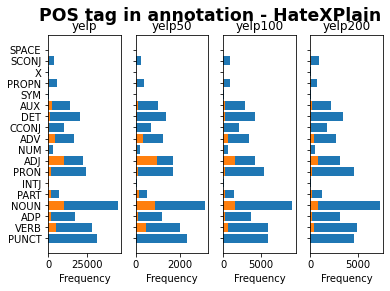

In [17]:
from data.yelp_hat.spacy_pretok_dataset import SpacyPretokenizeYelpHat
from tqdm.notebook import tqdm
import spacy
from spacy.tokens import Doc

cnt = dict()
SPLIT = ['yelp', 'yelp50', 'yelp100', 'yelp200']

spacy_model = spacy.load('en_core_web_sm')

for split in SPLIT:
    
    # Load dataset
    dataset = SpacyPretokenizeYelpHat(root=dataset_path, split=split, spacy_model=spacy_model, lemma=True, lower=True)
    tokens = dataset.data['text_tokens']
    rationale = dataset.data['ham']

    # Add punctuation to separate sentences
    for i in range(len(tokens)):
        tokens[i].append('.')
        rationale[i].append(0)

    flatten_token = [tk for sent in tokens for tk in sent]
    flatten_rationale = [r for sent in rationale for r in sent]

    nlp = spacy.load('en_core_web_sm')
    doc = Doc(nlp.vocab, words=flatten_token)
    pos = [tk.pos_ for tk in nlp(doc)]
    
    # Start counting
    cnt_pos = dict()
    cnt_tok = dict()
    cnt_pos_total = dict()
    cnt_tok_total = dict()
    
    for p, r, t in tqdm(zip(pos, flatten_rationale, flatten_token), total=len(flatten_rationale), desc=split):
    
        cnt_pos_total[p] = cnt_pos_total.get(p, 0) +1
        cnt_tok_total[t] = cnt_tok_total.get(t, 0) +1

        if r > 0:
            cnt_pos[p] = cnt_pos.get(p, 0) + 1
            cnt_tok[t] = cnt_tok.get(t, 0) + 1
            
    cnt[split] = {
        'pos' : cnt_pos,
        'tok' : cnt_tok,
        'pos_total': cnt_pos_total,
        'tok_total': cnt_tok_total
    }
    
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10*len(SPLIT),10)

fig, axes = plt.subplots(1, len(SPLIT), sharey=True)
fig.suptitle('POS tag in annotation - Yelp HAT', fontsize='xx-large', fontweight='black')

for ax, pos_freq, split in zip(axes, cnt.values(), cnt.keys()):
    
    cnt_pos_total = pos_freq['pos_total']
    cnt_pos = pos_freq['pos']

    ax.barh(width=cnt_pos_total.values(), y=list(cnt_pos_total.keys()))
    ax.barh(width=cnt_pos.values(), y=list(cnt_pos.keys()))

    ax.invert_yaxis()

    ax.set_xlabel('Frequency')
    ax.set_title(split)

plt.savefig(path.join(tmp_path, 'posfreq_yelphat'), dpi=600)



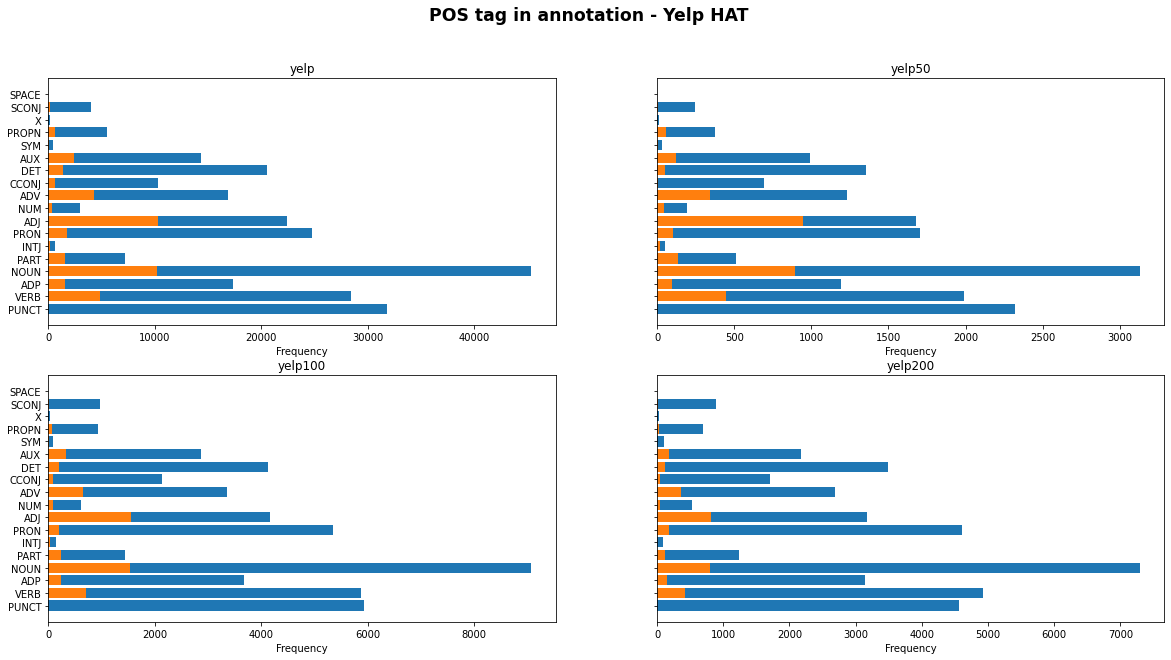

In [26]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

fig, axes = plt.subplots(2, 2, sharey=True)
fig.suptitle('POS tag in annotation - Yelp HAT', fontsize='xx-large', fontweight='black')

for ax, pos_freq, split in zip(axes.flatten(), cnt.values(), cnt.keys()):
    
    cnt_pos_total = pos_freq['pos_total']
    cnt_pos = pos_freq['pos']

    ax.barh(width=cnt_pos_total.values(), y=list(cnt_pos_total.keys()))
    ax.barh(width=cnt_pos.values(), y=list(cnt_pos.keys()))

    ax.invert_yaxis()

    ax.set_xlabel('Frequency')
    ax.set_title(split)

plt.savefig(path.join(tmp_path, 'posfreq_yelphat'), dpi=600)

In [27]:
(cnt_pos['VERB'] + cnt_pos['NOUN'] + cnt_pos['ADJ']) / sum(cnt_pos.values())

0.6202916160388822

## Making of heuristic

In [17]:
from data.yelp_hat.spacy_pretok_dataset import SpacyPretokenizeYelpHat
import spacy
from spacy.tokens import Doc
from modules.utils import hightlight
import torch


# Load dataset
dataset = SpacyPretokenizeYelpHat(root=dataset_path, split='yelp50')
tokens = dataset.data['text_tokens'].tolist()
rationale = dataset.data['ham'].tolist()

flatten_token = [tk for sent in tokens for tk in sent]
flatten_rationale = [r for sent in rationale for r in sent]

nlp = spacy.load('en_core_web_sm')

docs = [Doc(nlp.vocab, words=sent) for sent in tokens]
tokenized_docs = list(nlp.pipe(docs))
pos_filter = [[tk.pos_ in [''] for tk in d] for d in tokenized_docs]
stop_filter = [[not tk.is_stop for tk in d] for d in tokenized_docs]
mask = [pos_ and stop_ for pos_, stop_ in zip(pos_filter, stop_filter)]


token_freq = dict()
flatten_token = [tk for sent in tokens for tk in sent]
flatten_rationale = [r for sent in rationale for r in sent]

for t, r in zip(flatten_token, flatten_rationale):
    if r: token_freq[t] = token_freq.get(t, 0) + 1

total_freq = sum(token_freq.values())
token_freq = {k: v/total_freq for k, v in token_freq.items()}

heuristics = []
for sent_tokens, sent_mask in zip(tokens, mask):
    heuris_map = [token_freq.get(tk, 0) for tk in sent_tokens]
    heuris_map = [h * float(m) for h, m in zip(heuris_map, sent_mask)]
    heuristics.append(heuris_map)

tensor_heuristics = [torch.tensor(h) for h in heuristics]
for i in range(20):
    display(HTML(hightlight(tokens[i], tensor_heuristics[i])))

## Statistics on annotation

In [26]:
from data.yelp_hat.spacy_pretok_dataset import SpacyPretokenizeYelpHat
from tqdm.notebook import tqdm

cnt = dict()

for split in ['train', 'val', 'yelp50', 'yelp100', 'yelp200']:
    
    # Load dataset
    dataset = SpacyPretokenizeYelpHat(root=dataset_path, split=split)
    tokens = dataset.data['text_tokens']
    rationale = dataset.data['ham']

    # Add punctuation to separate sentences
    for i in range(len(tokens)):
        tokens[i].append('.')
        rationale[i].append(0)

    flatten_token = [tk for sent in tokens for tk in sent]
    flatten_rationale = [r for sent in rationale for r in sent]

    nlp = spacy.load('en_core_web_sm')
    doc = Doc(nlp.vocab, words=flatten_token)
    pos = [tk.pos_ for tk in nlp(doc)]
    
    # Start counting
    cnt_pos = dict()
    cnt_tok = dict()
    cnt_pos_total = dict()
    cnt_tok_total = dict()
    
    for p, r, t in tqdm(zip(pos, flatten_rationale, flatten_token), total=len(flatten_rationale), desc=split):
    
        cnt_pos_total[p] = cnt_pos_total.get(p, 0) +1
        cnt_tok_total[t] = cnt_tok_total.get(t, 0) +1

        if r > 0:
            cnt_pos[p] = cnt_pos.get(p, 0) + 1
            cnt_tok[t] = cnt_tok.get(t, 0) + 1
            
    cnt[split] = {
        'pos' : cnt_pos,
        'tok' : cnt_tok,
        'pos_total': cnt_pos_total,
        'tok_total': cnt_tok_total
    }    
    
for split in cnt:
    print('=== Most frequent pos in', split,"===")
    _count = cnt[split]['pos']
    total = sum(_count.values())
    percentage = {k: c/total for k, c in _count.items()}
    sorted_percentage = sorted(percentage.items(), key=lambda item: -item[1])
    sorted_key = [p[0] for p in sorted_percentage]
    sorted_values = [p[1] for p in sorted_percentage]
    cumulated_percentage = {'+'.join(sorted_key[:i]): sum(sorted_values[:i]) for i in range(1, len(sorted_percentage)) }
    cumulated_percentage = {k: v for k, v in cumulated_percentage.items() if v < 0.8}
    display(cumulated_percentage)
    print()

for split in cnt:
    print('=== Most 10 frequent highlighted tokens in', split,"===")
    _count = cnt[split]['tok']
    total = sum(_count.values())
    percentage = {k: c/total for k, c in _count.items()}
    sorted_percentage = sorted(percentage.items(), key=lambda item: -item[1])
    display(sorted_percentage[:10])
    print()

train:   0%|          | 0/177113 [00:00<?, ?it/s]

val:   0%|          | 0/76039 [00:00<?, ?it/s]

yelp50:   0%|          | 0/17702 [00:00<?, ?it/s]

yelp100:   0%|          | 0/50788 [00:00<?, ?it/s]

yelp200:   0%|          | 0/41352 [00:00<?, ?it/s]

=== Most frequent pos in train ===


{'ADJ': 0.25449385052034057,
 'ADJ+NOUN': 0.5081117067872034,
 'ADJ+NOUN+VERB': 0.628473317215039,
 'ADJ+NOUN+VERB+ADV': 0.7342934230351448,
 'ADJ+NOUN+VERB+ADV+AUX': 0.794772066295245}


=== Most frequent pos in val ===


{'ADJ': 0.2583930266678174,
 'ADJ+NOUN': 0.5107448002071286,
 'ADJ+NOUN+VERB': 0.6309657374643998,
 'ADJ+NOUN+VERB+ADV': 0.7397082937775092,
 'ADJ+NOUN+VERB+ADV+AUX': 0.7998619142142055}


=== Most frequent pos in yelp50 ===


{'ADJ': 0.28684290489213005,
 'ADJ+NOUN': 0.558189000303859,
 'ADJ+NOUN+VERB': 0.6949255545426922,
 'ADJ+NOUN+VERB+ADV': 0.7988453357642055}


=== Most frequent pos in yelp100 ===


{'ADJ': 0.26185636856368566,
 'ADJ+NOUN': 0.5210027100271003,
 'ADJ+NOUN+VERB': 0.6409214092140921,
 'ADJ+NOUN+VERB+ADV': 0.7501693766937669}


=== Most frequent pos in yelp200 ===


{'ADJ': 0.24665856622114216,
 'ADJ+NOUN': 0.49119076549210205,
 'ADJ+NOUN+VERB': 0.6202916160388822,
 'ADJ+NOUN+VERB+ADV': 0.7308626974483596,
 'ADJ+NOUN+VERB+ADV+AUX': 0.7876670716889429}


=== Most 10 frequent highlighted tokens in train ===


[('be', 0.04877536003363818),
 ('not', 0.02915308875573776),
 ('food', 0.02337152668278496),
 ('great', 0.023301447142506745),
 ('good', 0.021128981393882057),
 ('service', 0.020112828059847928),
 ('the', 0.014786782998703528),
 ('very', 0.0137706296646694),
 ('and', 0.012649357020217947),
 ('place', 0.012018641157714005)]


=== Most 10 frequent highlighted tokens in val ===


[('be', 0.04574091654440321),
 ('not', 0.03029256925865194),
 ('great', 0.024941745059117976),
 ('food', 0.023043065504444637),
 ('good', 0.02261154742383706),
 ('service', 0.018037455769396738),
 ('very', 0.014499007508414603),
 ('the', 0.013635971347199448),
 ('place', 0.012945542418227323),
 ('well', 0.011909899024769138)]


=== Most 10 frequent highlighted tokens in yelp50 ===


[('not', 0.03372835004557885),
 ('great', 0.02552415679124886),
 ('good', 0.025220297781829232),
 ('food', 0.024612579762989972),
 ('service', 0.02127013065937405),
 ('be', 0.019750835612275905),
 ('love', 0.013369796414463689),
 ('very', 0.012154360376785172),
 ('place', 0.011850501367365542),
 ('well', 0.011546642357945914)]


=== Most 10 frequent highlighted tokens in yelp100 ===


[('be', 0.04217479674796748),
 ('not', 0.029132791327913278),
 ('good', 0.022357723577235773),
 ('great', 0.02100271002710027),
 ('food', 0.017953929539295393),
 ('the', 0.014566395663956639),
 ('service', 0.014397018970189702),
 ('well', 0.0130420054200542),
 ('very', 0.012703252032520325),
 ('and', 0.011348238482384823)]


=== Most 10 frequent highlighted tokens in yelp200 ===


[('be', 0.04343863912515188),
 ('not', 0.028250303766707167),
 ('the', 0.018529769137302553),
 ('good', 0.015492102065613609),
 ('great', 0.01488456865127582),
 ('i', 0.01488456865127582),
 ('service', 0.013061968408262455),
 ('to', 0.011239368165249088),
 ('very', 0.010935601458080195),
 ('well', 0.0106318347509113)]

## Making of heuristic

In [4]:
from data.yelp_hat.spacy_pretok_dataset import SpacyPretokenizeYelpHat
from sklearn.metrics import roc_auc_score

yelp50 = SpacyPretokenizeYelpHat(root=path.join(cache_path, 'dataset'), split='yelp50')

heuristic = yelp50.data['heuristic']
rationale = yelp50.data['ham']

heuristic = [h_value for h_vector in heuristic for h_value in h_vector]
rationale = [r_value for r_vector in rationale for r_value in r_vector]


roc_score = roc_auc_score(rationale, heuristic)
roc_score

0.8265129896457086

In [5]:
for split in ['train', 'val', 'yelp50', 'yelp100', 'yelp200']:
    dataset = SpacyPretokenizeYelpHat(root=path.join(cache_path, 'dataset'), split=split)
    heuristic = [h_value for h_vector in dataset.data['heuristic'] for h_value in h_vector]
    rationale = [r_value for r_vector in dataset.data['ham'] for r_value in r_vector]
    roc_score = roc_auc_score(rationale, heuristic)
    print(split, ':', roc_score)

train : 0.7541391231043293
val : 0.5661874525553442
yelp50 : 0.8265129896457086


yelp100 : 0.7344016876803974


yelp200 : 0.7240816255407233


In [48]:
from sklearn.metrics import average_precision_score
import numpy as np

for split in ['train', 'val', 'yelp50', 'yelp100', 'yelp200']:
    dataset = SpacyPretokenizeYelpHat(root=path.join(cache_path, 'dataset'), split=split)
    dataset.data = dataset.data[dataset.data['label'] > 0].reset_index()
    
    h_vectors = [np.array(h_vector)/sum(h_vector) for h_vector in dataset.data['heuristic']]
    h_vectors = [(h-h.min())/(h.max()-h.min()) for h in h_vectors]
    heuristic = np.concatenate(h_vectors)
    
    rationale = np.array([r_value for r_vector in dataset.data['ham'] for r_value in r_vector])
    auprc = average_precision_score(rationale, heuristic)
    
    print(split, ':', auprc)

train : 0.4562269398738891
val : 0.17548856110022187
yelp50 : 0.6546419989436125
yelp100 : 0.35043071747460613
yelp200 : 0.24948444005921566


In [41]:
heuristic.min()

0.0

In [13]:
sum(dataset.data['heuristic'][0])

0.1376063183475091

In [14]:
dataset.data['heuristic']

0      [0.0, 0.0015188335358444715, 0.0, 0.0, 0.0, 0....
1      [0.00212636695018226, 0.00030376670716889426, ...
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.000303766707168894...
3      [0.0, 0.0, 0.0, 0.00030376670716889426, 0.0, 0...
4      [0.0, 0.0, 0.00637910085054678, 0.0, 0.0148845...
                             ...                        
174    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006075334143...
175    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
176    [0.0, 0.002430133657351154, 0.0, 0.0, 0.0, 0.0...
177    [0.00030376670716889426, 0.0, 0.0, 0.0, 0.0, 0...
178    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...
Name: heuristic, Length: 179, dtype: object